# Star Type Classification

Classifying the star type of an unclassified star using its absolute temperature and absolute magnitude.

# Part I: Introduction

Not every star is the same! Stars of similar characteristics can be grouped into different categories, allowing anyone from astronomers to economists to glean the general characteristics of a star, such as age, magnitude, or origin, simply by knowing its "star type." For our project, we will consider two specific characteristics of stars, use them to classify an "unknown" star, and determine how accurately these two characteristics predict star type. A high accuracy would indicate that these characteristics have different ranges corresponding to unique star types, thus being good indicators of star type.

To obtain data on stars, we will be using the “Star dataset to predict star types” dataset from Kaggle, which consists of data for 240 observations (240 stars). The characteristics, or variables, are indicated along with the units of measurement as follows:
- Absolute Temperature (Kelvin)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
    {note: Mv= m - 2.5log[(d/10)^2]}
- Star colour (white, red, blue, etc.)
- Spectral class (B, A etc.)

The 6 different star types considered in this data set are given a generic numerical value for ease of use in classification and are as follows:
- Brown Dwarf (star type = 0)
- Red Dwarf (star type = 1)
- White Dwarf (star type = 2)
- Main sequence (star type = 3)
- Supergiant (star type = 4)
- Hypergiant (star type = 5)

Most stars, including the sun, are “main sequence stars”, fueled by nuclear fusion; the hotter they are, the brighter they shine. As stars begin to die, they become giants and supergiants. When these eventually explode, they become white dwarfs. Smaller stars shrink and get dimmer, transforming into cold, dark, black dwarfs. Essentially, star types display the different stages in the life cycle of stars (Enchanted Learning, 1999). Stars are usually classified in order of decreasing temperature or their spectral class- B, A, F, G, K, and M,  with B-type stars being the hottest (40000K) and M-type stars being the coolest (3200K) (NASA, 2022). 

For our classification, we will be using only **Absolute Temperature (K)** and **Absolute Magnitude (Mv)** to predict the **Star Type** of an unclassified star, to see if a different characteristic such as absolute magnitude can also be useful in classification. Our analysis will be guided by the question: “Can we create a classifier that can accurately classify the Star Type of an unclassified star?” All other variables will subsequently be removed from the data set.

# Part II: Preliminary exploratory data analysis

To begin, we created a Jupyter Notebook and attached all the packages we would need for our classification. We also set a random seed for when we split our dataset later.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)
library(shiny)

set.seed(777)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Next, we loaded the dataset from Kaggle and converted the column names, originally containing spaces, into a more usable format. Additionally, the star type column was of the wrong data type so we converted it into data type "factor". Finally, we select only the columns that we are interested in for our classification (absolute temperature, absolute magnitude, and star type). The data is now ready for us to use.

To give a sense of how the data looks now, we have shown the first 6 and last 6 rows.
    
{note: the dataset has 240 observations, so there are 240 rows. Additionally, the data is currently organised in order of increasing star type (0-6).}

In [2]:
raw_data <- read_csv("https://raw.githubusercontent.com/uchou92/dcsi-100-2023w1-group-28/main/6_class_csv%5B1%5D.csv", col_names=FALSE,
             skip=1)

colnames(raw_data) <- c("abs_temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color", "spectral_class")

star_data <- raw_data|>
        mutate(star_type = as_factor(star_type))|>
        mutate(star_type = fct_recode(star_type, "star_type" = "star_type"))|>
        select(abs_magnitude, star_type, abs_temperature)

h3("Table. 1: First 6 rows of wrangled data set")
    head(star_data) 
h3("Table. 2: Last 6 rows of wrangled data set")
tail(star_data)

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): X6, X7
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `star_type = fct_recode(star_type, star_type = "star_type")`.
Caused by warning:
! Unknown levels in `f`: star_type”


Shiny tags cannot be represented in plain text (need html)

abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
16.12,0,3068
16.60,0,3042
18.70,0,2600
16.65,0,2800
20.06,0,1939
16.98,0,2840


Shiny tags cannot be represented in plain text (need html)

abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
-7.67,5,21904
-9.93,5,38940
-10.63,5,30839
-10.73,5,8829
-11.23,5,9235
-7.80,5,37882


We can also visualise the relationship between absolute temperature and absolute magnitude with respect to star type. We already see that the different star types are grouped in different regions on the plot, indicating that we should have some success with our classifier. For example, all observations of star type 0 (Brown Dwarf) are found at high values of absolute magnitude and low values of absolute temperature, while star type 5 (Hypergiant) is the only star type found at very low absolute magnitudes.

{note: this data is unstandardized and axes not to scale}

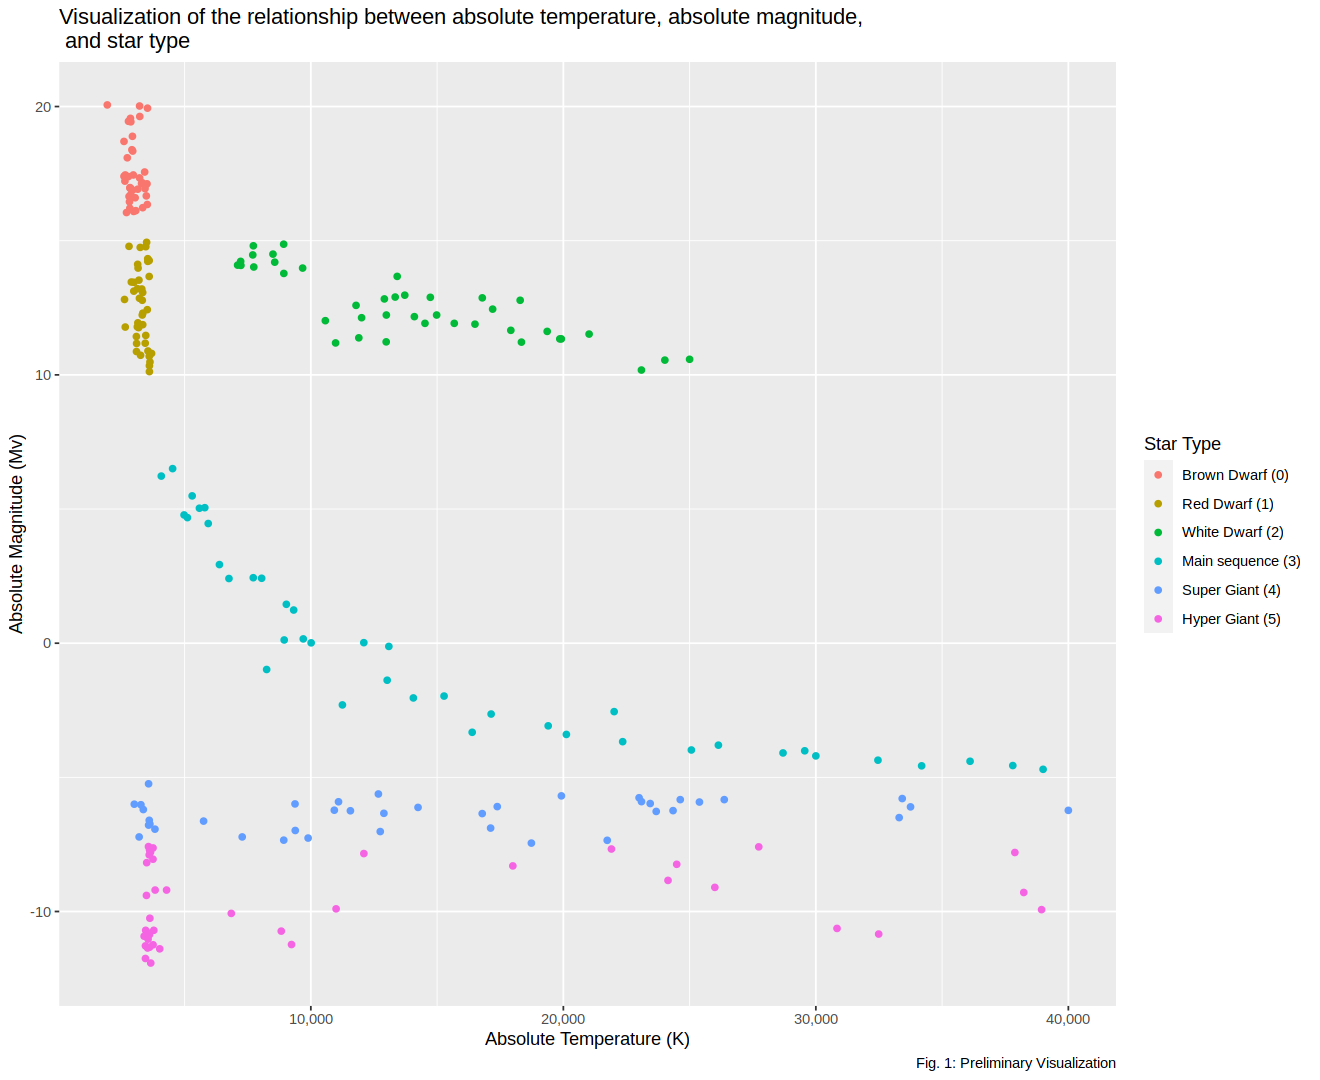

In [21]:
summary_plot <- star_data |>
    ggplot(aes(x = abs_temperature, y = abs_magnitude, color = star_type))+
            geom_point()+
            scale_color_hue(labels = c("Brown Dwarf (0)", "Red Dwarf (1)", "White Dwarf (2)","Main sequence (3)", 
                                       "Super Giant (4)", "Hyper Giant (5)")) +
            labs(x = "Absolute Temperature (K)", y = "Absolute Magnitude (Mv)", color = "Star Type") +
            ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, \n and star type") +
            scale_x_continuous(labels = scales::comma_format())+
            labs(caption = "Fig. 1: Preliminary Visualization")
summary_plot

options(repr.plot.width = 11, repr.plot.height = 6)

The first step to beginning our classification is to split our data into a training and testing set. We used a 75% training-testing split and stratified by star type to avoid class imbalance in either dataset.

In [4]:
data_split <- star_data |>
            initial_split(prop = 0.75, strata = star_type)

data_training <- training(data_split)
data_testing <- testing(data_split)

To give an overview of what our training set looks like, we have summarised how many of each star type is present. Since there were 240 original observations, 75% means 30 observations of each star type in our training set. If we don't, then there there must be missing data.

{note: there is no missing data!}

In [5]:
summary_training <- data_training |>
                    group_by(star_type) |>
                    summarize(count = n()) |>
                    arrange(desc(count))
h3("Table. 3: Distribution of star type in training set")
summary_training

Shiny tags cannot be represented in plain text (need html)

star_type,count
<fct>,<int>
0,30
1,30
2,30
3,30
4,30
5,30


# Part III: Classification

We will be performing classification using the K-nearest neighbours algorithm to classify star type using absolute temperature and absolute magnitude. First, we will tune for K so we know how many neighbours to consider. 

## Tuning for K

To begin tuning, we created a recipe with the training data. Our data contains only our two predictor variables (absolute temperature and absolute magnitude) and our response variable (star type), so we can simply set our recipe to predict star type using all variables (denoted '~.'). We want to standardize both predictor variables by scaling and centering about a mean of 0 and standard deviation of 1 to ensure all data is on a comparable scale and contributes equally to K-nearest distance calculations performed by the algorithm.

In [6]:
star_recipe <- recipe(star_type ~., data_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

To determine the best value for K, we need to perform cross-validation, essentially splitting the training data into a new training and testing set and testing for different K-values to determine the value with the highest accuracy. We will use 5-fold cross-validation and stratify by star type again.

In [7]:
star_vfold <- vfold_cv(data_training, v = 5, strata = star_type)

We have chosen to test K-values ranging from 1 to 10 because this is the most commonly suitable range.

In [8]:
kvals <- tibble(neighbors = seq(from = 1, to = 10))

To tune the algorithm, we pass the 'tune()' argument to the nearest_neighbor function and give the specifications. We will use the 'kknn' engine, classification mode, and weight_func = "rectangular" so the algorithm uses the straight line distance between observations and nearest neighbours.

In [9]:
star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Finally, we combine everything into a workflow and tune for K.

In [10]:
star_workflow <- workflow() |>
                    add_recipe(star_recipe) |>
                    add_model(star_spec) |>
                    tune_grid(resamples = star_vfold, grid = kvals)

Now, we can collect our results and see which K-value had the highest accuracy. To better visualize the trend in accuracy, we also plotted a graph of K-value (x-axis) vs. accuracy (y-axis).

Shiny tags cannot be represented in plain text (need html)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9500000,5,0.016197089,Preprocessor1_Model01
2,accuracy,multiclass,0.9500000,5,0.016197089,Preprocessor1_Model02
3,accuracy,multiclass,0.9277778,5,0.014163943,Preprocessor1_Model03
4,accuracy,multiclass,0.9111111,5,0.022222222,Preprocessor1_Model04
5,accuracy,multiclass,0.8666667,5,0.010393493,Preprocessor1_Model05
6,accuracy,multiclass,0.8722222,5,0.006804138,Preprocessor1_Model06
7,accuracy,multiclass,0.8500000,5,0.006804138,Preprocessor1_Model07
8,accuracy,multiclass,0.8500000,5,0.006804138,Preprocessor1_Model08
9,accuracy,multiclass,0.8555556,5,0.013608276,Preprocessor1_Model09


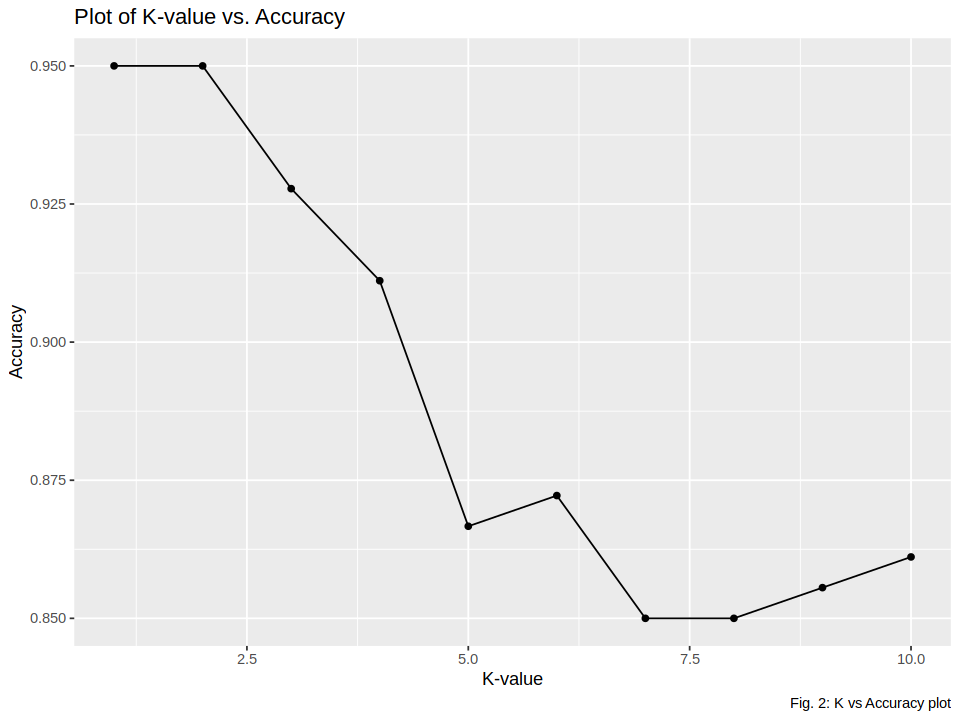

In [23]:
star_results <- star_workflow |> 
                    collect_metrics() |>
                    filter(.metric == "accuracy")
h3("Table. 4: Results of tuning")
star_results

star_plot <- star_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K-value", y = "Accuracy")+
                ggtitle("Plot of K-value vs. Accuracy")+
                labs(caption = "Fig. 2: K vs Accuracy plot")
star_plot

options(repr.plot.width = 8, repr.plot.height = 6)

From both the table and graph we can see that the maximum accuracy is 95% and corresponds to both K = 1 and K = 2. We have chosen to use K = 2 because using K = 1 would likely lead to overfitting our data (further explanation in Part IV: Discussion).

## Measuring the accuracy of our classifier

We can evaluate the performance of our classifier using the testing set and determining accuracy. Since we tuned the classifier using the training set, we can use the classifier to predict all of the star types of the observations in the testing set, and then compare the prediction with the true value.

First, we recreate the specifications for the algorithm with K = 2. Then, we combine this new specification with the recipe we created earlier and fit it to the training data.

In [12]:
star_main_spec <- nearest_neighbor(weight_func = "rectangular", n = 2 ) |>
                set_engine("kknn") |> 
                set_mode("classification")

star_fit <- workflow() |>
            add_recipe(star_recipe) |> 
            add_model(star_main_spec) |>
            fit(data_training)

Next, we use the algorithm to predict the star types of the testing set. The bind_cols function adds the predicted class directly to our data set so we can easily compare the predicted and actual class. The first 6 predictions are shown for reference.

In [13]:
star_predictions <- star_fit |>
                     predict(data_testing) |>
                     bind_cols(data_testing)
h3("Table. 5: First 6 predictions of testing set")
head(star_predictions)

Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
0,18.70,0,2600
1,10.48,1,3628
2,11.89,2,16500
2,14.20,2,8570
2,14.47,2,7700
2,14.08,2,7230


So far, our classifier appears to be perfectly accurate. To easily see how the classifier does for the entire testing set without looking through 60 rows of data, we can compute the confusion matrix which tells us how many predictions were made for each star type and how they compare with the 'truth' - the actual star type.

{note: since the testing set was 25% of the original 240 observations, it contains 60 observations: 10 of each star type}

In [14]:
star_matrix <- conf_mat(star_predictions, truth = star_type, estimate = .pred_class)
h3("Table. 6: Confusion matrix")
star_matrix

Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0  8  0  0
         4  0  0  0  2  9  0
         5  0  0  0  0  1 10

Now we can see that our classifier made 3 mistakes: twice, it predicted a star was of type 4 (Supergiant) when it was actually type 3 (Main Sequence), and predicted one star was of type 5 (Hypergiant) when it was actually of type 4 (Supergiant). 3 mistakes out of 60 predictions is pretty accurate! We can also use the metrics function to compute the numerical accuracy.

In [15]:
star_metrics <- star_predictions |>
                metrics(truth = star_type, estimate = .pred_class) |>
                filter(.metric == "accuracy")
h3("Table. 7: Accuracy of classifier")
star_metrics

Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.95


Our classifier is 95% accurate! We can also revisit Fig. 1 to see where our classifier struggled. First, we need to determine the absolute magnitude and absolute temperature of these 3 stars:

In [16]:
star_mistakes1 <- star_predictions |>
                filter(star_type == "3", .pred_class == "4")
h3("Table. 8: Falsely predicted class 4")
star_mistakes1

star_mistakes2 <- star_predictions |>
                filter(star_type == "4", .pred_class == "5")
h3("Table. 9: Falsely predicted class 5")
star_mistakes2

Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
4,-3.32,3,16390
4,-4.57,3,34190


Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
5,-7.346,4,21738


In [17]:
mistake_star_1 <- c(16390, -3.32)

mistake_star_2 <- c(34190, -4.57)

mistake_star_3 <- c(21738, -7.346)

Now we can annotate the graph to see where exactly these stars lie relative to the others. The predicted star type is indicated by the corresponding number, the actual star type is indicated by the colour.

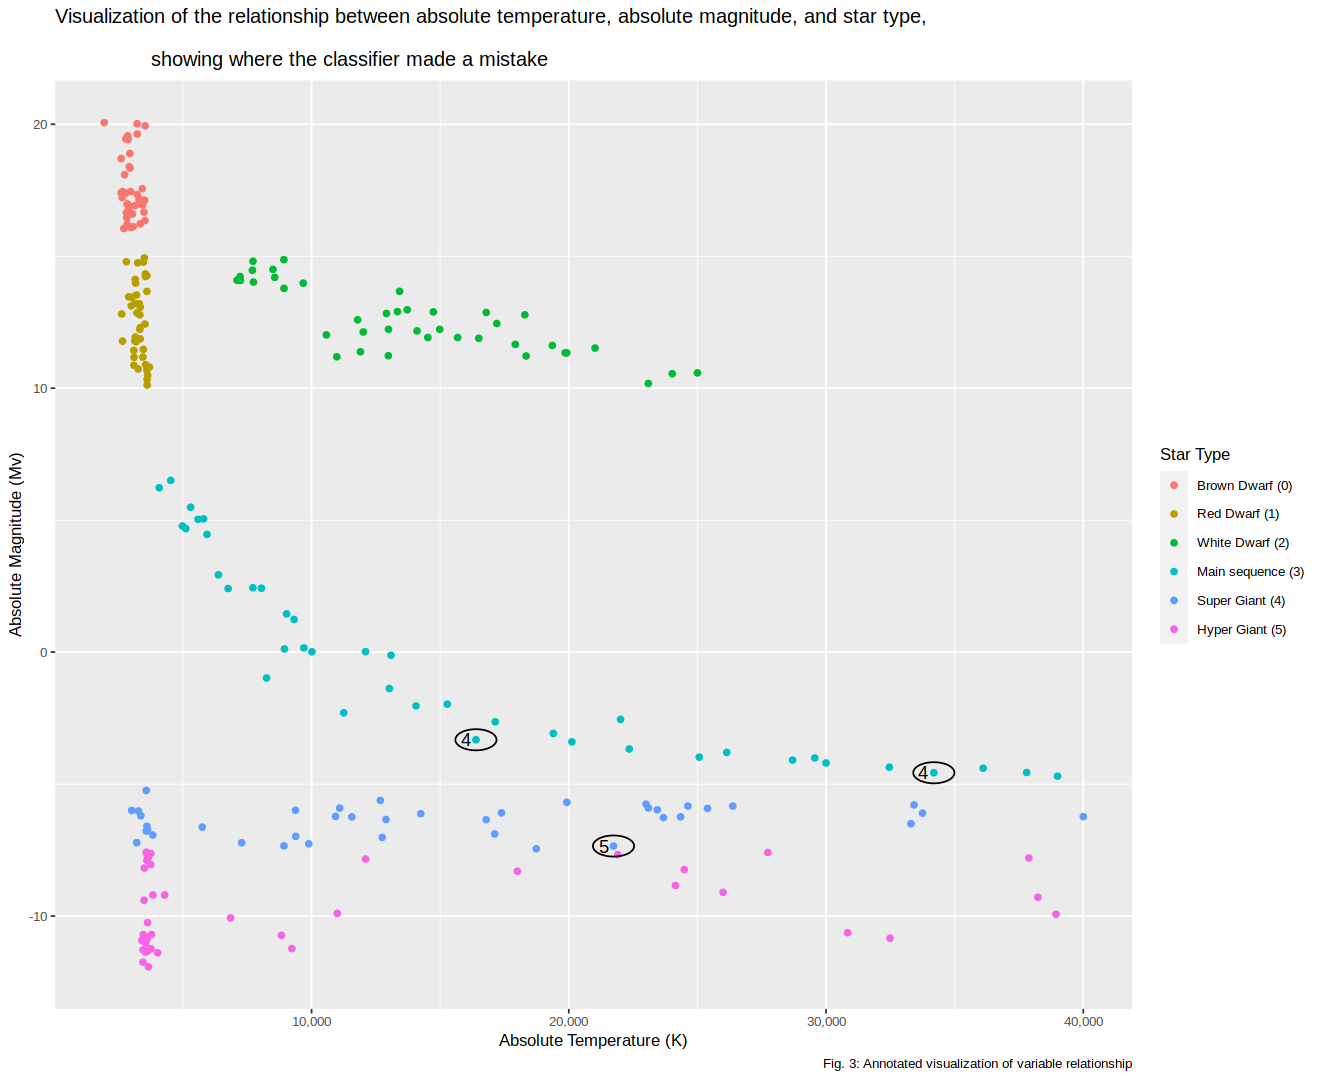

In [25]:
mistakes_plot <- summary_plot +
        annotate("path", 
                 x = mistake_star_1[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_1[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 16000, y =  -3.32, label = "4") +
        theme(text = element_text(size = 10))+
            annotate("path", 
                 x = mistake_star_2[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_2[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 33750, y =  -4.57, label = "4") +
        theme(text = element_text(size = 10))+
        annotate("path", 
                 x = mistake_star_3[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_3[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 21350, y =  -7.346, label = "5") +
        theme(text = element_text(size = 10))+
        ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, and star type, \n 
                showing where the classifier made a mistake") +
        labs(caption = "Fig. 3: Annotated visualization of variable relationship")
mistakes_plot

options(repr.plot.width = 11, repr.plot.height = 9)

Considering this data is unscaled, we know that vertical distances are actually around 10x smaller since absolute temperature is measured in tens of thousands. Therefore, it is possible to interpret that these observations are plotted very close to stars of the type they were mistaken for. It is then easy to understand how the classifier made an error!

## Classifying an unlabelled star using our model

One way we can apply our classifier is to predict the star type of a star not included in the Kaggle dataset. Alpha Canis Majoris, commonly known as the star Sirius, lies in the Canis Major constellation and is one of the brightest and most identifiable stars in the night sky. Its companion, Sirius B, has an absolute magnitude of 11.3Mv and an absolute temperature of 25000K (Sirius, n.d.). 

In [19]:
siriusB <- tibble(abs_magnitude = 11.3, abs_temperature = 25000)

h3("Table. 10: Characteristics of Sirius")
siriusB

Shiny tags cannot be represented in plain text (need html)

abs_magnitude,abs_temperature
<dbl>,<dbl>
11.3,25000


We know that Sirius B is a White Dwarf (star type 2). We can use our classifier to predict its star type and see if it matches.

In [20]:
siriusB_prediction <-predict(star_fit, siriusB)

h3("Table. 11: Predicted star type of Sirius")
siriusB_prediction

Shiny tags cannot be represented in plain text (need html)

.pred_class
<fct>
2


Our classifier has predicted Sirius B as star type 2, which does correspond to White Dwarf!

# Part IV: Discussion

Using classification, we successfully determined the star type of an "unknown" star using Absolute Temperature (K) and Absolute Magnitude (Mv). We began by tuning the parameter for K, exploring how many neighbors to consider to ascertain the star type of a given data point. Setting K = 2 implies considering the two nearest neighbors when making predictions. Subsequently, the majority class among these two neighbors is assigned as the predicted class for the data point. Achieving a 95% accuracy with this model supported our hypothesis, demonstrating our ability to create a classifier that accurately identifies the Star Type of an unclassified star.

The classification of a single unclassified point is illustrated in Table 10 and Table 11. However, we encountered minor classification errors, as depicted in Figure 3. These errors were anticipated since, in Figure 3, the points are relatively close to other star types. Therefore, with K = 2, a certain level of error is expected, as reflected in the 95% accuracy. Examining the accuracy plot for different K-values in Figure 2, we observed that K = 1 provides the same accuracy as K = 2. Nevertheless, opting for K = 2 is preferred because K = 1 is more susceptible to outliers, where a single point in the training set could significantly impact predictions as the classifier matches each new observation to its closest neighbor in the training data. This would be overfitting the data, as the training data has too much influence on the model. Additionally, we were uncertain in Fig. 2 because as per examples in the textbook, K-value vs accuracy plots tend to increase, and then decrease. However, our plot never increases it only decreases after K = 2.

Looking ahead, these findings can be beneficial for users unfamiliar with stars, enabling them to easily identify star types based on specific characteristics. For example, Figure 3 visually distinguishes each star type on the plot, aiding individuals in swiftly identifying unknown stars without manual comparisons on a table.

Upon completion, several questions arise. What other variables, apart from absolute temperature and magnitude, can impact the classification of star types or be used in classification? Are there exceptions due to these additional variables? Furthermore, how can classification contribute to real-world applications in Astronomy and organizations like NASA? Additionally, we are interested in assessing whether this classification increases efficacy and reduces the time required for those working in astronomy to identify unknown stars across the universe.

# Part V: References

Baidya, D. (n.d.). Star dataset to predict star types. Kaggle. 
    https://www.kaggle.com/datasets/deepu1109/star-dataset

Enchanted Learning. (1999, January 1). Star Classification. Enchanted Learning. 
    https://www.enchantedlearning.com/subjects/astronomy/stars/startypes.shtml 
    
NASA. (2022, October 12). Types. NASA. 
https://universe.nasa.gov/stars/types/#:~:text=Scientists%20call%20a%20star%20that,millions%20to%20billions%20of%20years. 

Sirius. (n.d.). Oxford Reference. 
    https://www.oxfordreference.com/display/10.1093/oi/authority.20110803100508723